# Gradient Map

In [ ]:
import xarray as xr
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [ ]:
HRES = xr.open_zarr("/geodata2/Gencast/HRES_uv.zarr", decode_timedelta=True)\
        .sel(level=300)\
            .mean("initial_time")\
                .rename({"u_component_of_wind":"u", "v_component_of_wind":"v"})\
                .isel(time=1 * 4)
                

ENS = xr.open_dataset("/geodata2/S2S/DL/GC_output/IFS-ENS/uv300hPa.nc", decode_timedelta=True)\
    .isel(time=1 * 2, ensemble=0)
        
# d-1 00z부터 시작
GenCast = xr.open_dataset("/geodata2/Gencast/uv_300hPa.nc", decode_timedelta=True)\
    .rename({"u_component_of_wind":"u", "v_component_of_wind":"v"})\
    .isel(time=1 * 2 - 1, sample=0)

model = {
    "HRES": HRES,
    "ENS": ENS,
    "GenCast": GenCast
}

# 세 모델의 |∇KE| magnitude를 모두 구해서 합친 뒤, 합이 최대가 되는 lat band를 찾는 코드로 변경

# 1. 각 모델의 |∇KE| magnitude 계산 및 합산
magnitude_sum = None
for model_name, model_data in model.items():
    model_data = model_data.fillna(0)
    KE = 0.5 * (model_data['u']**2 + model_data['v']**2)
    dKE_dy, dKE_dx = mpcalc.geospatial_gradient(KE)
    dKE_dy = np.asarray(dKE_dy)
    dKE_dx = np.asarray(dKE_dx)
    mag = np.sqrt(dKE_dx**2 + dKE_dy**2)
    magnitude = xr.DataArray(mag, coords=KE.coords, dims=['lat', 'lon'])
    if magnitude_sum is None:
        magnitude_sum = magnitude.copy(deep=True)
    else:
        magnitude_sum += magnitude

# 2. lat band(위도 띠) 중에서 magnitude_sum이 최대가 되는 band 찾기
lat = magnitude_sum.lat
lon = magnitude_sum.lon
weights = np.cos(np.radians(lat))  # shape = (lat,)

lat_len, lon_len = magnitude_sum.shape
window_size = int(lon_len * 0.025)

best_band_start = 0
max_weighted_mean = -np.inf

for j in range(lon_len - window_size + 1):
    band = magnitude_sum[:, j:j+window_size]         # shape = (lat, window_size)
    band_mean = np.nanmean(band, axis=1)             # shape = (lat,)
    valid_mask = ~np.isnan(band_mean)
    if np.any(valid_mask):
        weighted_mean = np.average(
            band_mean[valid_mask],
            weights=weights[valid_mask]
        )
        if weighted_mean > max_weighted_mean:
            max_weighted_mean = weighted_mean
            best_band_start = j

print(f"Best band (summed over all models) starts at longitude index: {best_band_start}")
print(f"Max weighted mean (summed): {max_weighted_mean}")


MergeError: Automatic alignment is not supported for in-place operations.
Consider aligning the indices manually or using a not-in-place operation.
See https://github.com/pydata/xarray/issues/3910 for more explanations.

/tmp/ipykernel_1924822/3465017127.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  GenCast = xr.open_dataset("/geodata2/Gencast/uv_300hPa.nc").mean("sample").isel(time=1)
/home/hiskim1/.conda/envs/hiskim1_gencast/lib/python3.11/site-packages/pint/facets/plain/quantity.py:1006: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


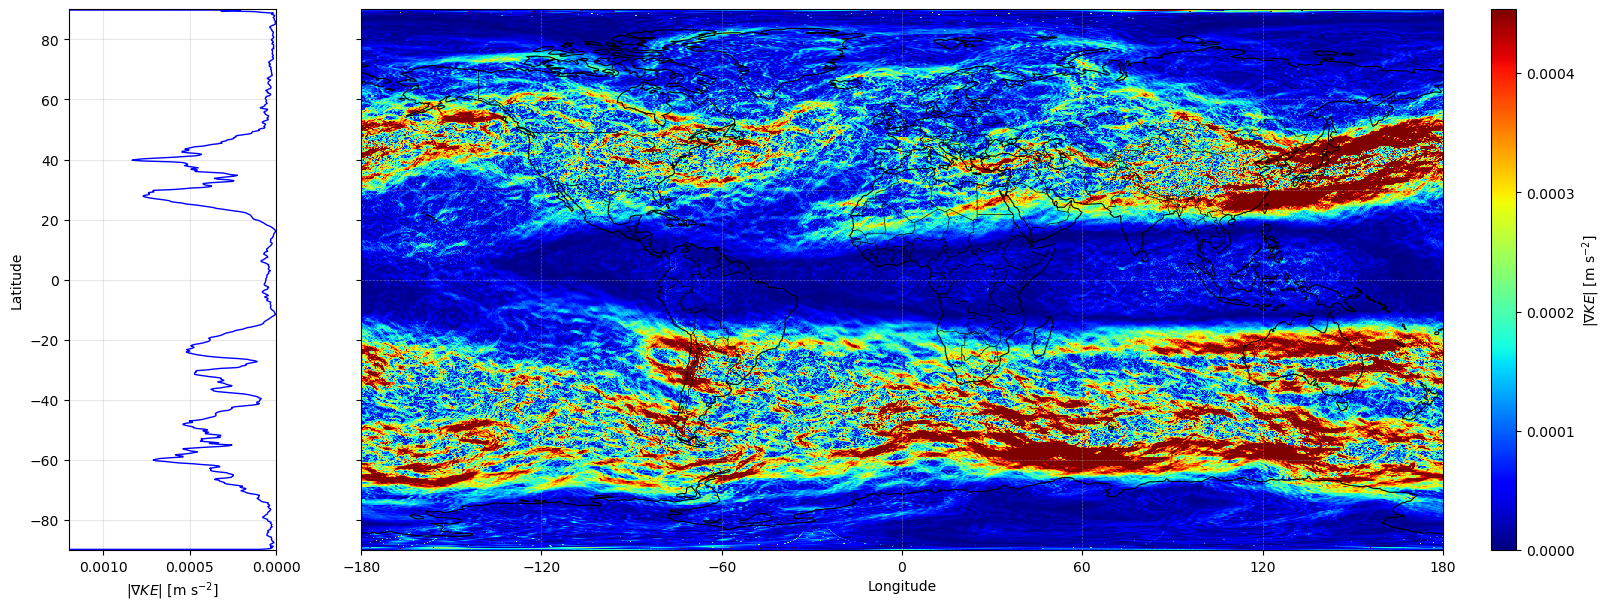

In [44]:
import matplotlib.gridspec as gridspec

GenCast = xr.open_dataset("/geodata2/Gencast/uv_300hPa.nc").mean("sample").isel(time=1)

u = GenCast['u_component_of_wind'].metpy.quantify()
v = GenCast['v_component_of_wind'].metpy.quantify()

KE = 0.5 * (u**2 + v**2)

lat = KE.lat.values
lon = KE.lon.values
# gradient 계산
dKE = mpcalc.gradient(KE) 
# 튜플 언팩
dKE_dy, dKE_dx = mpcalc.geospatial_gradient(KE)
dKE_dy = np.asarray(dKE_dy)   # memoryview → ndarray
dKE_dx = np.asarray(dKE_dx)
mag = np.sqrt(dKE_dx**2 + dKE_dy**2)
magnitude = xr.DataArray(mag, coords=KE.coords, dims=['lat', 'lon'])
# 좌표
band_start = 130.5  # 혹은 직접 지정 ex: np.where((lon>=120) & (lon<150))[0]
band_slice = slice(band_start, band_start + 9)
band_vals = magnitude.sel(lon=band_slice).mean("lon")

# Figure 레이아웃
fig = plt.figure(figsize=(16,6), constrained_layout=True)
gs = gridspec.GridSpec(1, 21, figure=fig, width_ratios=[1,1,1,1,1, 0.3,
                                                        2,2,2,2,2,2,2,2,2,2,2,2,2,2,
                                                        0.6])
ax_prof = fig.add_subplot(gs[0, 0:5])
ax_grid = fig.add_subplot(gs[0, 6:20], projection=ccrs.PlateCarree())  # 마지막(20) 제외
cax     = fig.add_subplot(gs[0, 20])                                   # colorbar 전용 축

ax_prof.plot(band_vals, KE.lat, lw=1, color='b')
ax_prof.set_ylabel('Latitude')
ax_prof.set_xlabel(r'$|\nabla KE|$ [m s$^{-2}$]')
ax_prof.invert_xaxis()
# x_max = np.nanpercentile(band_vals, 99)
ax_prof.set_xlim(0.0012, 0)
ax_prof.ticklabel_format(axis='x', style='sci', scilimits=(-4,2))
ax_prof.set_ylim(lat.min(), lat.max())
ax_prof.grid(alpha=0.3)
# (선택) 위도 0, ±30, ±60 선만 ytick
ticks = [-80,-60,-40,-20,0,20,40,60,80]
ax_prof.set_yticks(ticks)
# (2) 오른쪽: 지도
if hasattr(mag, "magnitude"):
    mag_plot = mag.magnitude
else:
    mag_plot = mag
vmax = np.nanpercentile(mag_plot, 95)
pcm = ax_grid.pcolormesh(lon, lat, mag_plot, 
                         cmap='jet', shading='auto', vmin=0, vmax=vmax,
                         transform=ccrs.PlateCarree()
                         )
ax_grid.coastlines(resolution='110m', linewidth=0.8, color='black')
ax_grid.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
ax_grid.add_feature(cfeature.LAND, facecolor='white', zorder=0)
ax_grid.add_feature(cfeature.OCEAN, facecolor='white', zorder=0)

ax_grid.set_xlabel('Longitude')
ax_grid.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

ax_grid.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax_grid.set_yticks(np.arange(-80,   81, 20), crs=ccrs.PlateCarree())
gl = ax_grid.gridlines(draw_labels=False, linestyle='--', linewidth=0.5, alpha=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size':9}
gl.ylabel_style = {'size':9}

# axis labels (optional; gridline labels generally suffice)
ax_grid.set_xlabel('Longitude')
ax_grid.set_ylabel('')
ax_grid.yaxis.set_tick_params(labelleft=False) 

cb = fig.colorbar(pcm, cax=cax, orientation='vertical')
cb.set_label(r'$|\nabla KE|$ [m s$^{-2}$]')

In [17]:
lon

array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02], dtype=float32)

NameError: name 'lat2d' is not defined

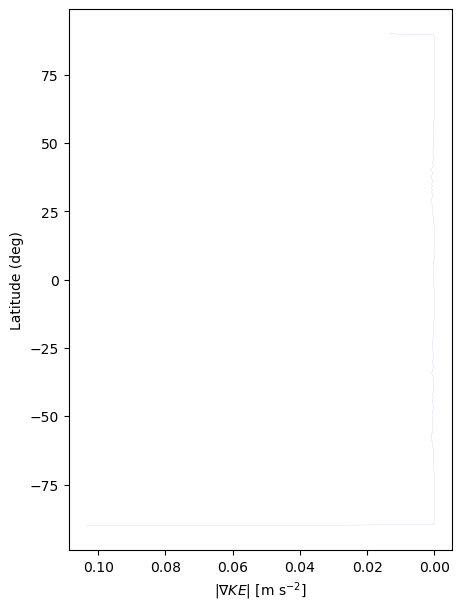

In [25]:


# Figure 레이아웃
fig = plt.figure(figsize=(16,6), constrained_layout=True)
gs = gridspec.GridSpec(1, 20, figure=fig)

# (1) 왼쪽: 위도 프로파일 (세로축 위도)
ax_prof = fig.add_subplot(gs[0, 0:5])  # 2/12 폭
ax_prof.plot(band_vals, KE.lat, lw=0.05, color='b')
ax_prof.set_ylabel('Latitude (deg)')
ax_prof.set_xlabel(r'$|\nabla KE|$ [m s$^{-2}$]')
ax_prof.invert_xaxis()
# ax_prof.set_xlim(0.002, 0)
ax_prof.ticklabel_format(axis='x', style='sci', scilimits=(-10,2))
ax_prof.set_ylim(lat2d.min(), lat2d.max())
ax_prof.grid(alpha=0.3)

# (선택) 위도 0, ±30, ±60 선만 ytick
ticks = [-60,-30,0,30,60]
ax_prof.set_yticks(ticks)

# (2) 오른쪽: 지도
ax_map = fig.add_subplot(gs[0, 1:], projection=ccrs.PlateCarree())
ax_map.set_global()
ax_map.coastlines(resolution='110m', linewidth=0.8)
ax_map.add_feature(cfeature.BORDERS, linewidth=0.5)
ax_map.add_feature(cfeature.LAND, facecolor='white', zorder=0)
ax_map.add_feature(cfeature.OCEAN, facecolor='white', zorder=0)
if hasattr(mag, "magnitude"):
    mag_plot = mag.magnitude
else:
    mag_plot = mag

vmax = np.nanpercentile(mag_plot, 95)
pc = ax_map.pcolormesh(
    lon2d, lat2d, mag_plot,
    cmap='jet', shading='auto',
    vmin=0, vmax=vmax,
    transform=ccrs.PlateCarree()
)

lat, lon = magnitude.lat, magnitude.lon


# 선택된 band 표시 (두 경도 경계)
lon_selected = lon[band_start: band_start+72]
lon_min = float(lon_selected.min())
lon_max = float(lon_selected.max())

# band 경계 선
ax_map.plot([lon_min]*2, [ -89.9, 89.9], color='black', lw=1.0, transform=ccrs.PlateCarree())
ax_map.plot([lon_max]*2, [ -89.9, 89.9], color='black', lw=1.0, transform=ccrs.PlateCarree())

# 간단: 다각형 patch (경도 wrap 주의 – band가 dateline 넘지 않는다고 가정)
poly_lats = np.linspace(-89.9, 89.9, 50)
poly1 = np.vstack([np.full_like(poly_lats, lon_min), poly_lats]).T
poly2 = np.vstack([np.full_like(poly_lats, lon_max), poly_lats[::-1]]).T
poly = np.vstack([poly1, poly2])
path = mpath.Path(ccrs.PlateCarree().transform_points(ccrs.PlateCarree(),
                                                      poly[:,0], poly[:,1])[:, :2])
patch = mpatches.PathPatch(path, facecolor='gray', alpha=0.25, transform=ccrs.PlateCarree())
ax_map.add_patch(patch)

cb = fig.colorbar(pc, ax=ax_map, orientation='vertical', pad=0.015, shrink=0.92)
# 
# cax = divider.append_axes("right", size="2.2%", pad=0.15)
# cb = plt.colorbar(pc, cax=cax)
cb.set_label(r'$|\nabla KE|$ [m s$^{-2}$]')

fig.suptitle(f"{model_name} |∇KE| map + latitude profile (band {lon_min:.1f}°–{lon_max:.1f}°)")
# plt.tight_layout()
plt.show()